# HO model of Luggye 

We use several datasets to create a mesh of Luggye glacier, which is refined near the terminus to eventually accommodate calving physics. This is based on an already-created .exp file describing a polygon for Luggye's outline (obtained as the intersection of the RGI outline with our own DEM). We have also manually delineated Luggye's terminus position from the date most closely aligning with the DEM (DEM from 18 October, 2025, terminus from 20 October). After meshing the outline, we refine based on distance from the terminus. We extrude the mesh and solve the HO approximation. We let the terminus advance with flow and apply a simple calving step. 

In [1]:
######################
### issm functions ###
######################

from model import model
from bamg import bamg
from expread import expread
from issm_helper import *

######################
### python modules ###
######################

import geopandas as gpd
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import FuncFormatter
import numpy as np
import os
import rasterio
from scipy.ndimage import distance_transform_edt
from shapely import LineString, points, distance, contains_xy as contains
from shapely.geometry import Polygon, Point
from shapely.ops import nearest_points, split
import tqdm

###################
### directories ###
###################

data_dir = '/home/mielebzu/data/'
dem_dir = data_dir + 'dems'
bed_dir = data_dir + 'bed'
bed_file = bed_dir + '/thickness_RGI60-15.02373.tif'
dem_file = dem_dir + '/luggye_2025_ds.tif'
exp_dir = data_dir + 'exp_files'
os.chdir(exp_dir)

could not import shapefile, PyShp has not been installed, no shapefile reading capabilities enabled


## Mesh

In [2]:
min_cellsize, max_cellsize = 50, 50 #in metres
refined = 20 #size of the refined mesh cells

md = model()
md = bamg(md, 'domain', 'DomainOutline_20260126_162319.exp', 'hmax', max_cellsize, 'hmin', min_cellsize)

At least one contour was not correctly oriented and has been re-oriented


In [3]:
md.geometry

   geometry parameters:
         surface                : N/A             -- ice upper surface elevation [m]
         thickness              : N/A             -- ice thickness [m]
         base                   : N/A             -- ice base elevation [m]
         bed                    : N/A             -- bed elevation [m]

## Load the terminus curve

...and extend it so that it reaches the edges of the domain. In fact, it's best to extend it a ways beyond the edge of the domain, since the terminus line will later be used to split the outline into lake/ice subsets. For that later step, we need to be sure that the terminus line intersects the outer boundary twice. 

In [4]:
terminus = LineString([ #copy/pasted from GEEDiT
    (90.31877330330583, 28.09807611129586),
    (90.31919172791216, 28.098104504384743),
    (90.31958869484636, 28.0979909319842),
    (90.31985691574785, 28.09783950192981),
    (90.32003930596086, 28.097602892042097),
    (90.32007149246904, 28.097356817205473),
    (90.3201358654854, 28.097176992929565),
    (90.32029679802629, 28.096940381581167),
    (90.32055429009172, 28.09669430522543),
    (90.32076886681291, 28.096438763797273),
    (90.32100490120622, 28.096154828163456),
    (90.32110146073076, 28.095889820894154),
    (90.32110146073076, 28.095539631713223),
    (90.32101563004228, 28.095113724412702)
])

terminus_gdf = gpd.GeoSeries([terminus], crs = 'EPSG:4326').to_crs(epsg = 32645) #reproject 
terminus = terminus_gdf.iloc[0]
terminus = terminus.segmentize(refined)

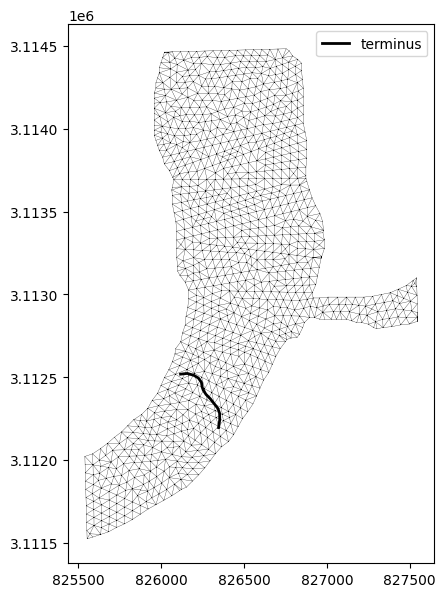

In [5]:
mx, my = md.mesh.x, md.mesh.y
elts = md.mesh.elements - 1
tx, ty = np.array(terminus.coords).T

plt.figure(figsize = (7, 7))
plt.triplot(mx, my, elts, color = 'k', linewidth = 0.2)
plt.plot(tx, ty, 'k-', linewidth = 2, label = 'terminus')
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

## Refine mesh

We will write a scalar field which has its largest values close to the terminus LineString, and approaches zero far away from it. 

In [6]:
terminus = extend_terminus(md, terminus = terminus, ε = 10) #extend to the sides of the domain
tx, ty = np.array(terminus.coords).T
terminus_0 = terminus #and immortalize the initial terminus position

d = np.array([terminus.distance(Point(xi, yi)) for xi, yi in zip(md.mesh.x, md.mesh.y)]) #distances from terminus, for each mesh node
L = 50 #half-width of the zone of increased refinement (metres from the terminus)
d = np.exp(-(d/L)**2) #cornert "d" into an exponential which peaks close to the terminus
md = bamg(md, 'field', d, 'err', 1e-3, 'hmin', refined, 'hmax', max_cellsize) #good value for "err" obtained by brute force

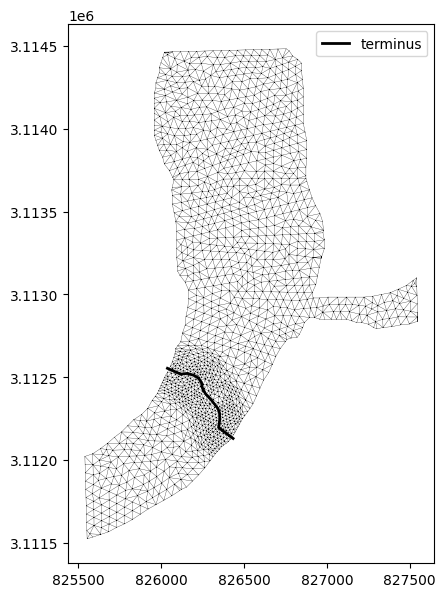

In [7]:
mx, my = md.mesh.x, md.mesh.y #redefine for new mesh
elts = md.mesh.elements - 1
nodes, elements = md.mesh.numberofvertices, md.mesh.numberofelements

plt.figure(figsize = (7, 7))
plt.triplot(mx, my, elts, color = 'k', linewidth = 0.2)
plt.plot(tx, ty, 'k-', linewidth = 2, label = 'terminus')
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

## Identify and label boundaries

Use function ```issm_helper.plot_boundary(md, i = index_1, j = index_2, ...)``` to show boundary subsets. Use brute force to identify which subsets correspond to which boundaries.

In [8]:
# plot_boundary(md, i = 144, j = None, terminus = terminus, fontsize = 10)

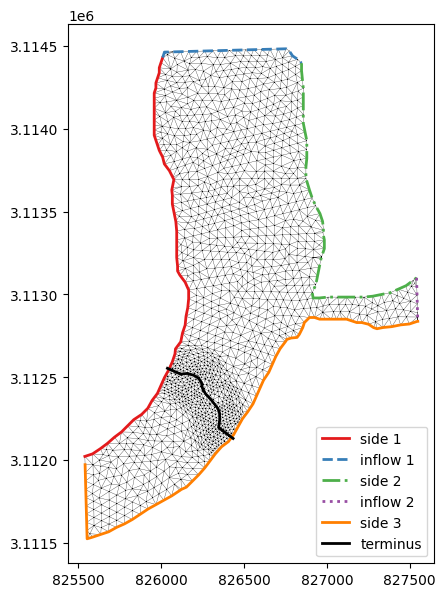

In [9]:
ice_bnd_nodes = order_boundary(md)

##############################################
### set boundaries by brute-force plotting ###
##############################################

side_1 = ice_bnd_nodes[:74] #these values discovered as above
inflow_1 = ice_bnd_nodes[73:95]
side_2 = ice_bnd_nodes[94:140]
inflow_2 = ice_bnd_nodes[139:145]
side_3 = ice_bnd_nodes[144:]

Gamma = {
    'side 1':   side_1,
    'inflow 1': inflow_1,
    'side 2':   side_2,
    'inflow 2': inflow_2,
    'side 3':   side_3,
}

###########################################
### label potentially important subsets ###
###########################################

Γ_side1 = np.isin(np.arange(mx.size), side_1)
Γ_side2 = np.isin(np.arange(mx.size), side_2)
Γ_side3 = np.isin(np.arange(mx.size), side_3)
Γ_inflow1 = np.isin(np.arange(mx.size), inflow_1)
Γ_inflow2 = np.isin(np.arange(mx.size), inflow_2)

Γ_sides = Γ_side1 | Γ_side2 | Γ_side3
Γ_inflow = Γ_inflow1 | Γ_inflow2
Γ = Γ_sides | Γ_inflow

############
### plot ###
############

cmap = plt.get_cmap('Set1')
styles = ['-', '--', '-.', ':']

fig, ax = plt.subplots(figsize = (7, 7))
ax.triplot(mx, my, elts, linewidth = 0.2, color = 'k')
for i, (name, nodes) in enumerate(Gamma.items()):
    ax.plot(mx[nodes], my[nodes], lw = 2, color = cmap(i), linestyle = styles[i % 4], label = name)
ax.plot(tx, ty, color ='k', lw = 2, label = 'terminus')
ax.set_aspect('equal')
ax.legend()
plt.show()

## Separate the domain into ice and water

We ```split``` the outline along the terminus polyline, defining ```ice_mask``` and ```lake_mask``` to be the collection of nodes contained in either subset. However, because our mesh may now be finer than the initial polygon, some boundary mesh nodes may fall slightly beyond its extent. Therefore, begin by drawing a new polygon based on the boundary nodes, and give it a small buffer to ensure that every node is properly contained.

Once the ice mask is set, also define the ice and ocean levelsets based on distance from the terminus. 

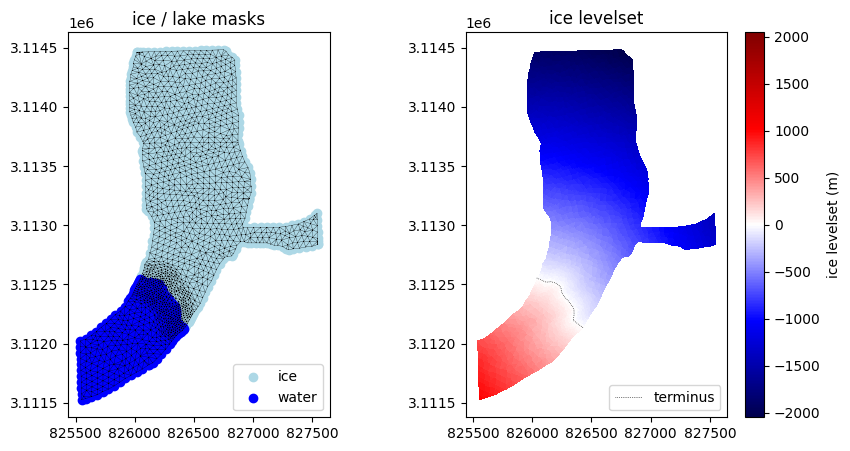

In [10]:
####################################
### separate into ice/lake masks ###
####################################

Ω = md.miscellaneous.domain

parts = split(Ω, terminus) #then, split it across the terminus
Ω_2, Ω_1 = parts.geoms 

ice_mask = contains(Ω_1, mx, my) #(I only know which is which by trial and error)
lake_mask = contains(Ω_2, mx, my)
md.mask.ice_mask = ice_mask.copy()
terminus_0 = terminus

########################
### create levelsets ###
########################

ϕ_ice = distance(points(mx, my), terminus)
ϕ_ice[ice_mask] *= -1
md.mask.ice_levelset = ϕ_ice.copy() #negative upstream of terminus, pos downstream, 0 @ term
md.mask.ocean_levelset = np.ones_like(lake_mask) #grounded > 0, floating < 0, 0 @ GL

############
### plot ###
############

ϕ_max = np.max(np.abs(md.mask.ice_levelset))
norm = TwoSlopeNorm(vmin = -ϕ_max, vcenter = 0, vmax = ϕ_max)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

ax1.scatter(mx[ice_mask], my[ice_mask], color = 'lightblue', label = 'ice')
ax1.scatter(mx[lake_mask], my[lake_mask], color = 'blue', label = 'water')
ax1.triplot(mx, my, elts, linewidth = 0.2, color = 'k')
ax1.set_aspect('equal')
ax1.legend()
ax1.set_title('ice / lake masks')

ϕ_plot = ax2.tripcolor(mx, my, elts, md.mask.ice_levelset, norm = norm, cmap = 'seismic')
ax2.plot(tx, ty, 'k', linewidth = 0.5, linestyle = 'dotted', label = 'terminus')
ax2.set_aspect('equal')
ax2.legend()
ax2.set_title('ice levelset')
cbar = fig.colorbar(ϕ_plot, ax = ax2)
cbar.set_label('ice levelset (m)')

plt.show()

## Material parameters and initial configuration
Open DEM data and project onto mesh points, set necessary variables.  

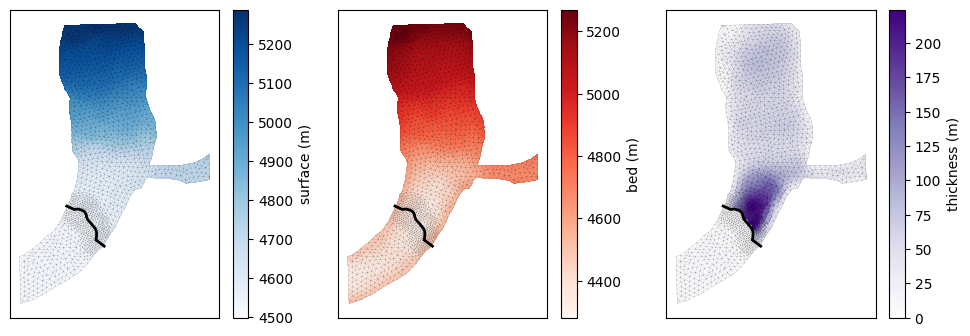

In [11]:
################
### geometry ###
################

waterline = 4500 #determined by looking at duckling tracks over DEM
s = interpolate_raster(md, dem_file)
s[~ice_mask] = waterline
H = interpolate_raster(md, bed_file)
bed = s - H

H[~ice_mask] = 0 #make sure not to do this before setting the bed!
H_0 = H.copy()
s_0 = s.copy()

################
### velocity ###
################

u = (0, 0)

############
### plot ###
############

fig, axes = plt.subplots(1, 3, figsize = (12, 4), sharey = True)
thickness = H.copy()
thickness[~ice_mask] = 0

for ax, field, cmap, label in [
    (axes[0], s, 'Blues', 'surface (m)'),
    (axes[1], bed, 'Reds', 'bed (m)'),
    (axes[2], thickness, 'Purples', 'thickness (m)'),
]:
    pc = ax.tripcolor(mx, my, elts, field, cmap = cmap)
    ax.triplot(mx, my, elts, color = 'k', linewidth = 0.15, alpha = 0.4)
    ax.plot(tx, ty, 'k-', linewidth = 2)
    fig.colorbar(pc, ax = ax, label = label)
    ax.set_aspect('equal')
    ax.set_xticks([], [])
    ax.set_yticks([], [])

plt.show()

## Initialize the model

In [12]:
initialization_params = {'approximation': 'HO', 'temperature': 273.15, 
                         'dirichlet_x': Γ_sides, 'dirichlet_y': Γ_sides, 'dirichlet_H': Γ_inflow,
                         'bed': bed, 'waterline': 4500}
                        
initialize_model(md, **initialization_params)

      no smb.mass_balance specified: values set as zero


In [13]:
md.transient.requested_outputs

['default']

## Solve

In [14]:
Δt = 1
model_time = 10
num_timesteps = int(model_time/Δt)
solver_opts = {'friction': 1000, 'thickness_inflow': H_0}

for step in tqdm.trange(num_timesteps):

    u, H, s = coupled_solve(md, Δt, thickness = H, velocity = u, **solver_opts)
    # u = diagnostic_solve(md, thickness = H, velocity = u, **solver_opts)
    # H, s = prognostic_solve(md, Δt, thickness = H, velocity = u, **solver_opts)
    terminus, H, s = advance_terminus(md, Δt, thickness = H, velocity = u, terminus = terminus, **solver_opts)
    
    if step == 0:
        terminus, H, s = simple_calve(md, radius = 100, terminus = terminus, thickness = H, surface = s)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.80s/it]


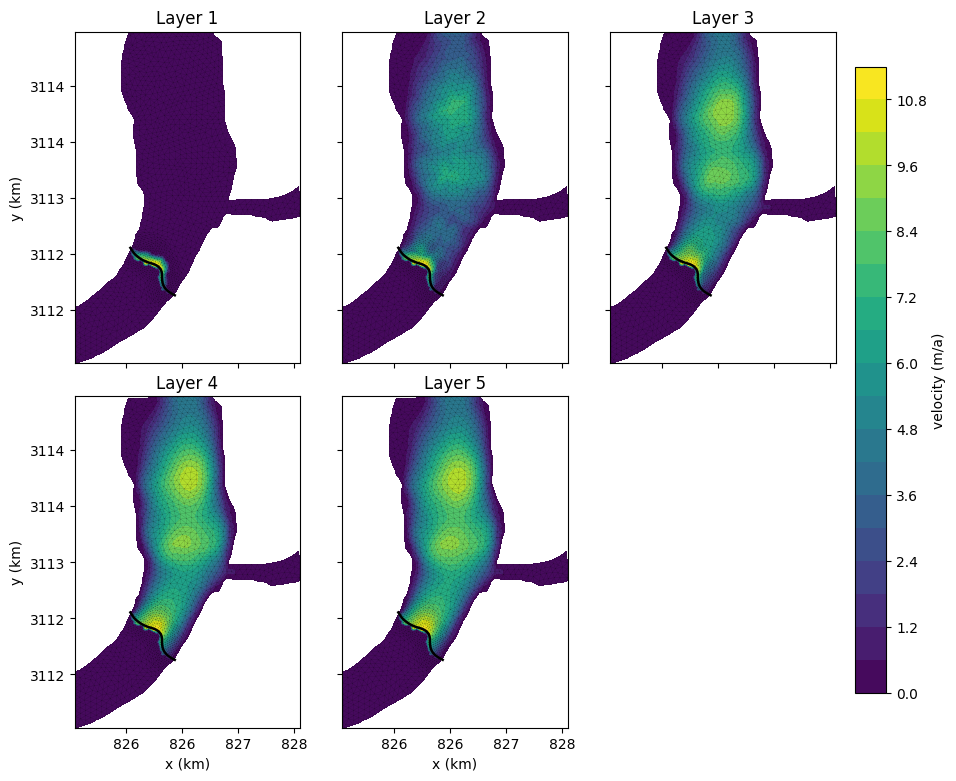

In [15]:
km = FuncFormatter(lambda v, _: f'{v/1000:.0f}')
speed = np.hypot(u[0], u[1]).ravel()
# speed[md.mask.ice_levelset > 0] = np.nan

x0, y0 = np.asarray(terminus_0.xy[0]), np.asarray(terminus_0.xy[1])
x1, y1 = np.asarray(terminus.xy[0]), np.asarray(terminus.xy[1])

def fmt_ax(ax):
    ax.set_aspect('equal')
    ax.xaxis.set_major_formatter(km)
    ax.yaxis.set_major_formatter(km)
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')

try:
    n2 = md.mesh.numberofvertices2d
    L = md.mesh.numberoflayers
    x, y = md.mesh.x2d, md.mesh.y2d
    elts = md.mesh.elements2d - 1
    phi = np.asarray(md.mask.ice_levelset).ravel()[:n2]
    vmax = speed.max()

    cols = int(np.ceil(L**0.5))
    rows = int(np.ceil(L/cols))
    fig, axes = plt.subplots(rows, cols, figsize = (4*cols, 4*rows), sharex = 'col', sharey = 'row',
                             gridspec_kw = {'wspace': -0.3, 'hspace': 0.1})
    axes = np.atleast_1d(axes).ravel()

    for k, ax in enumerate(axes):
        if k >= L:
            ax.axis('off')
            continue
        sl = slice(k*n2, (k + 1)*n2)
        c = ax.tricontourf(x, y, elts, speed[sl], levels = 20, vmin = 0, vmax = vmax)
        ax.triplot(x, y, elts, color = 'k', linewidth = 0.15, alpha = 0.4)
        ax.tricontour(x, y, elts, phi, levels = [0], colors = 'grey', linewidths = 1)
        ax.set(title = f'Layer {k + 1}')
        ax.set_aspect('equal')
        ax.xaxis.set_major_formatter(km)
        ax.yaxis.set_major_formatter(km)
        # ax.plot(x0, y0, '--', lw = 1.5, color = 'k')
        ax.plot(x1, y1, '-',  lw = 1.8, color = 'k')


    for ax in axes[-cols:]:
        ax.set_xlabel('x (km)')
    for ax in axes[::cols]:
        ax.set_ylabel('y (km)')

    fig.subplots_adjust(left = 0.07, right = 0.88, bottom = 0.08, top = 0.95)
    fig.colorbar(c, ax = axes[:L], fraction = 0.035, pad = 0.02, shrink = 0.9).set_label('velocity (m/a)')
    plt.show()

except AttributeError:
    x, y = md.mesh.x, md.mesh.y
    elts = md.mesh.elements - 1

    plt.figure()
    # speed[md.mask.ice_levelset > 0] = np.nan
    pc = plt.tripcolor(x, y, elts, speed)
    plt.triplot(x, y, elts, color = 'k', linewidth = 0.15, alpha = 0.4)
    plt.plot(x0, y0, '--', lw = 1, color = 'k')
    plt.plot(x1, y1, '-',  lw = 1, color = 'k')

    fmt_ax(plt.gca())
    plt.colorbar(pc, label = 'velocity (m/a)')
    plt.show()

## Thickness evolution

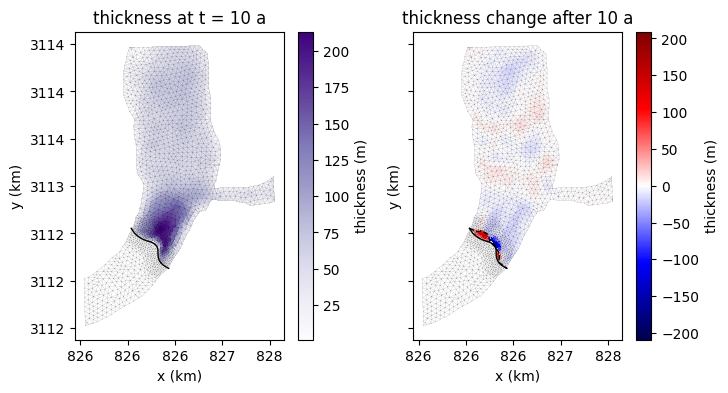

In [16]:
thickness = H.copy()
ΔH = H - H_0

try:
    thickness[md.mask.ice_levelset > 0] = np.nan
    ΔH[md.mask.ice_levelset > 0] = np.nan
except:
    proj = lambda x: project2d(md, x, 1)
    thickness[proj(md.mask.ice_levelset > 0)] = np.nan
    ΔH[proj(md.mask.ice_levelset) > 0] = np.nan

v = np.nanmax(np.abs(ΔH))

fig, axes = plt.subplots(1, 2, figsize = (8, 4), sharey = True)

pc0 = axes[0].tripcolor(mx, my, elts, thickness, cmap = 'Purples')
axes[0].triplot(mx, my, elts, color = 'k', linewidth = 0.15, alpha = 0.4)
# axes[0].plot(x0, y0, '--', lw = 1, color = 'k')
axes[0].plot(x1, y1, '-',  lw = 1, color = 'k')
fmt_ax(axes[0])
fig.colorbar(pc0, ax = axes[0], label = 'thickness (m)')
axes[0].set_title(f'thickness at t = {model_time} a')

pc1 = axes[1].tripcolor(mx, my, elts, ΔH, cmap = 'seismic', vmin = -v, vmax = v)
axes[1].triplot(mx, my, elts, color = 'k', linewidth = 0.15, alpha = 0.4)
axes[1].plot(x0, y0, '--', lw = 1, color = 'k')
axes[1].plot(x1, y1, '-',  lw = 1, color = 'k')
fmt_ax(axes[1])
fig.colorbar(pc1, ax = axes[1], label = 'thickness (m)')
axes[1].set_title(f'thickness change after {model_time} a')

plt.show()

## Next task...

Implement a calving law that makes physical sense. Ideas:

(1) Something to do with finding a strain rate contour near the terminus? 
(2) Just cut off anything that floats
(3) Prescribe a calving rate based on thickness/depth at each terminus point, and retreat perpendicular backward

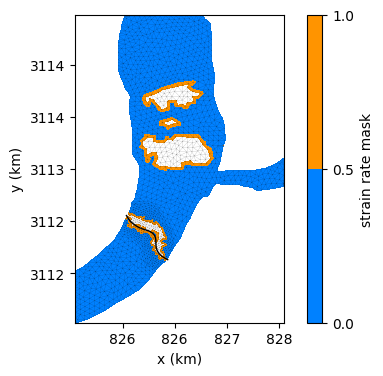

In [17]:
ε = effective_strain_rate(md, depth_averaged = True)
thresh = 0.2e-8
strain_rate_mask = ε > thresh

plt.figure(figsize = (6, 4))

vmin = np.min(ε)
vmax = np.max(ε)
pc = plt.tricontourf(mx, my, elts, strain_rate_mask, cmap = 'jet', levels = [0, 0.5, 1])
plt.triplot(mx, my, elts, color = 'k', linewidth = 0.15, alpha = 0.4)
# plt.plot(x0, y0, '--', lw = 1, color = 'k')
plt.plot(x1, y1, '-',  lw = 1, color = 'k')

fmt_ax(plt.gca())
plt.colorbar(pc, label = 'strain rate mask')
plt.show()

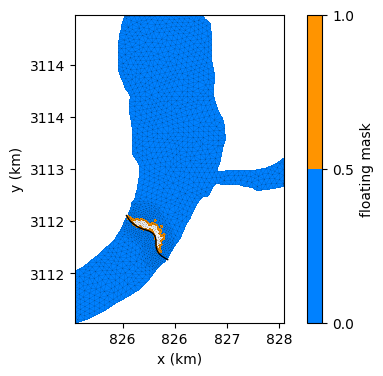

In [18]:
ρ_i = md.materials.rho_ice
ρ_w = md.materials.rho_water
ϱ = ρ_i/ρ_w

bed = md.miscellaneous.bed
waterline = md.miscellaneous.waterline

H2 = H.copy()
ice = project2d(md, (md.mask.ice_levelset <= 0).astype(float), 1) > 0.5 if hasattr(md.mesh, 'numberoflayers') else (md.mask.ice_levelset <= 0)

float_mask = ice & ((bed - waterline) < (-ϱ*H))

plt.figure(figsize=(6, 4))
pc = plt.tricontourf(mx, my, elts, float_mask.astype(float), levels=[0, 0.5, 1], cmap='jet')
plt.triplot(mx, my, elts, color='k', linewidth=0.15, alpha=0.4)
plt.plot(x1, y1, '-', lw=1, color='k')

fmt_ax(plt.gca())
plt.colorbar(pc, label='floating mask')
plt.show()